<a href="https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/KDD_cup_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [211]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
df_train = pd.read_csv('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train.data', sep='\t')

In [213]:
df_train.shape

(50000, 230)

In [214]:
df_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,80.0,NaN,4.0,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [215]:
df_test = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_test.data')
df_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,0.0,72.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4259232.0,NaN,NaN,...,NaN,xddq9ayfAo,RO12,NaN,taul,1K8T,PShj,iJzviRg,17VONbZnAuZ90atz,MF5EBmj,NaN,WVvO,9_Y1,vm5R,VpdQ,haYg,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,XREFJCi,NaN,7WwzJJY,OgPm,cJvF,FzaX,ch2oGfM,Al6ZaUT,P6pu4Vl,LM8l689qOp,NaN,ELof,7P5s,ZI9m,R4y5gQQWY8OodqDV,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,259.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,240.0,NaN,0.0,40.0,NaN,NaN,300.32,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4859550.0,NaN,NaN,...,NaN,cFHt0GoOh3,RO12,NaN,taul,1K8T,lK27,rsmctTK,7ONkRNQCK7,NaN,NaN,aFB2,9_Y1,t_4G,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,4ls8,cJvF,FzaX,Kgofc8E,oslk,S46Rt72,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,861.0,14.0,NaN,NaN,NaN,NaN,NaN,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,40.0,NaN,0.0,8.0,NaN,NaN,186.64,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,10038840.0,NaN,NaN,...,NaN,zcROj17IEC,RO12,NaN,taul,1K8T,oXaB,I6Bd3iM,bGUqwlz,NaN,NaN,6k5I,9_Y1,iVbl,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,0b0w,cJvF,FzaX,bBmOw16,oslk,CcdTy9x,LM8l689qOp,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1568.0,7.0,NaN,NaN,NaN,NaN,NaN,1232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448.0,560.0,NaN,4.0,88.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,116760.0,NaN,NaN,...,NaN,gOyq9ayE15,2Knk1KF,SEuy,taul,1K8T,tzKK,Te2s8CN,hOpRIhsUSP,x0xpMjN,smXZ,kVZt,9_Y1,vm5R,VpdQ,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,3yoa8Yv,NaN,XTbPUYD,XqfQ,UYBR,AU8pNoi,rDm6pd1,oslk,Q53Rkup,LM8l689qOp,NaN,kG3k,7P5s,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c,NaN
4,NaN,NaN,NaN,NaN,NaN,1197.0,7.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,125.0,NaN,8.0,40.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,257772.0,NaN,NaN,...,NaN,voArjIXt5a,onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890,NaN,taul,1K8T,80HR,fqeOwLG,nJy8d8N5V7yiy,IBmPo7a,NaN,oyu5,9_Y1,WIr3,VpdQ,kxE9,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,c02HCHI,NaN,_JdEa95,bOvW,cJvF,FzaX,fxJmel6,Al6ZaUT,WfsWw2A,LM8l689qOp,NaN,ELof,5Acm,ZI9m,iyHGyLCEkQ,am7c,NaN


In [216]:
y_train_appetency =pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_appetency.labels',header = None).loc[:, 0].astype('category')
y_train_appetency.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [217]:
y_train_upselling= pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_upselling.labels', header = None).loc[:, 0].astype('category')
y_train_upselling.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [218]:
y_train_churn = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
y_train_churn.head()

0   -1
1    1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

Change the lables from [-1, 1] to [0, 1]

In [221]:
y_train_appetency = (y_train_appetency.astype('int') + 1)/2
y_train_churn = (y_train_churn.astype('int') + 1)/2
y_train_upselling = (y_train_upselling.astype('int') + 1)/2

In [232]:
y_train_appetency.tail()

49995    1.0
49996    1.0
49997    0.0
49998    0.0
49999    0.0
Name: 0, dtype: float64

In [234]:
np.mean(y_train_appetency == 1) , np.mean(y_train_churn == 1) , np.mean(y_train_upselling == 1)

(0.0178, 0.07344, 0.07364)

### Preprocessing

In [222]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [223]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [224]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (50000, 230)


,dtype,nulls,num_uniques,value_counts
Var1,float64,49298,19,HC
Var2,float64,48759,3,nan:487590.0:12405.0:1
Var3,float64,48760,147,HC
Var4,float64,48421,5,nan:484210.0:15619.0:1518.0:227.0:1
Var5,float64,48513,572,HC
Var6,float64,5529,1487,HC
Var7,float64,5539,9,7.0:235300.0:13090nan:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var8,float64,50000,1,nan:50000
Var9,float64,49298,101,HC
Var10,float64,48513,535,HC


In [225]:
df_table = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']) # Using the second tbl_report function

df_table['dtype'].value_counts()

Table Shape (50000, 230)


float64    191
object      38
int64        1
Name: dtype, dtype: int64

In [226]:
df_float = df_table[df_table['dtype']== 'float64']
lst_empty_float_cols = list(df_float[df_float['nulls'] > len(df_train)*0.95 ].index)
print("Number of float cols where more than 95% of data is null = ",len(lst_empty_float_cols))

Number of float cols where more than 95% of data is null =  149


In [227]:
df_object = df_table[df_table['dtype']== 'object']
lst_empty_categorical_cols = list(df_object[df_object['nulls'] > len(df_train)*0.95 ].index)
print("Number of categorical cols where more than 95% of data is null = ",len(lst_empty_categorical_cols))

Number of categorical cols where more than 95% of data is null =  4


For now, let us drop all the categorical cols and float cols with >95% of data being null

In [228]:
categorical_cols = list(df_table[df_table['dtype']=='object'].index)
drop_cols = lst_empty_float_cols + categorical_cols
print("Total columns to be dropped =",len(drop_cols))

Total columns to be dropped = 187


In [229]:
df_train_kdd = df_train.drop(drop_cols,axis=1)
df_train_kdd = df_train_kdd.fillna(df_train_kdd.mean())

In [230]:
df_train_kdd.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var51,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,0.0,43652.006725,4.076907,9.0,4.190659,36,35.0,1350864.0,0.0,7333.110000,5.0,12.0,98671.065858,104.00000,168.0,117625.60,1175.000000,6.0,720.0,8.00000,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,142.0,38418.0,0.0,0.0,462.000000
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,0.0,43652.006725,5.408032,9.0,3.000000,26,0.0,2872928.0,3.0,151098.900000,25.0,2.0,58158.000000,40.00000,40.0,-356411.60,590.000000,72.0,0.0,-0.55388,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,32.0,238572.0,0.0,0.0,270.142137
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,0.0,43652.006725,6.599658,9.0,4.190659,130,518.0,1675776.0,0.0,16211.580000,40.0,58.0,98671.065858,312.00000,336.0,405104.00,3230.000000,114.0,5967.0,-28.00000,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,206.0,434946.0,0.0,0.0,270.142137
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,0.0,43652.006725,1.988250,9.0,4.190659,12,0.0,0.0,0.0,103084.052693,0.0,0.0,98671.065858,60.88866,0.0,-275703.60,916.112185,0.0,0.0,-14.00000,0.0,0.0,0.0,0.0,0.0,11.727665,294920.804255,0.0,0.0,0.0,0.0,0.0,270.142137
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,0.0,43652.006725,4.552446,18.0,3.000000,82,224.0,784448.0,0.0,37423.500000,0.0,0.0,89754.000000,32.00000,56.0,10714.84,215.000000,0.0,15111.0,58.00000,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,2.0,0.0,0.0,0.0,270.142137


In [233]:
X_train, X_val, y_train, y_val = train_test_split(df_train_kdd, y_train_churn, train_size=0.8, random_state=66, stratify=y_train_churn)

**All customers churn, we send everyone**

In [235]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

In [240]:
def do_classify(clf, parameters, df, 
                featurenames, 
                score_func, n_folds=5, n_jobs=1):
    # x test and ytest
    Xtrain= df
    ytrain= y_train
    # if not mask:
    #     print("using reuse split")
    #     Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'][featurenames], reuse_split['Xtest'][featurenames], reuse_split['ytrain'], reuse_split['ytest']
    # else: # mask is to be used
    #     print("using mask")
    #     Xtrain, Xtest, ytrain, ytest = X[reuse_split], X[~reuse_split], y[reuse_split], y[~reuse_split]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    # test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict 0.5 ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    # print("Accuracy on test data:     %0.2f" % (test_accuracy))
    # print(confusion_matrix(ytest, clf.predict(Xtest)))
    # print("########################################################")
    # return clf, dict(Xtrain=Xtrain, ytrain=ytrain, Xtest=Xtest, ytest=ytest)

In [241]:
pure_cat_vars = []
cont_vars = X_train.columns

In [242]:
# set up standardization
ss = StandardScaler()
# oe hot encoding
oh = OneHotEncoder()
# continuous variables need to be standardized
cont_pipe = Pipeline([("scale", ss)])
# categorical variables need to be one hot encoded
cat_pipe = Pipeline([('onehot', oh)])
# combine both into a transformer
transformers = [('cont', cont_pipe, cont_vars)]
# apply transformer to relevant columns. Nothing will be done for the rest
ct = ColumnTransformer(transformers=transformers, remainder="passthrough")
# create a pipeline so that we are not leaking data from validation to train in the individual folds
pipe = Pipeline(steps=[('ct', ct), ('model', LogisticRegression(max_iter=10000, penalty='l2'))])
# in paramgrid we dont use C but use model__C corresponding to the name in the pipeline
paramgrid = dict(model__C=[1000, 100, 10, 1, 0.1, 0.01, 0.001])

In [243]:
from sklearn.metrics import roc_auc_score
do_classify(pipe, paramgrid, X_train, 
                              cont_vars, 
                              score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'model__C': 1} 0.6452913039550889
############# based on standard predict 0.5 ################
Accuracy on training data: 0.93


In [244]:
# do_classify(clf, parameters, indf, 
#                 featurenames, targetname, target1val, 
#                 reuse_split, mask=False, 
#                 score_func=None, n_folds=5, n_jobs=1)

In [245]:
# Table report after dropping columns and filling na with 0
pretty_print(tbl_report(df_train_kdd, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])) 

Table Shape (50000, 43)


,dtype,nulls,num_uniques,value_counts
Var6,float64,0,1487,HC
Var7,float64,0,9,7.0:235300.0:130906.809495962753874:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var13,float64,0,2635,HC
Var21,float64,0,735,HC
Var22,float64,0,736,HC
Var24,float64,0,94,HC
Var25,float64,0,272,HC
Var28,float64,0,4168,HC
Var35,float64,0,14,HC
Var38,float64,0,30833,HC


# Gradient Boosting

In [246]:
from sklearn.ensemble import GradientBoostingClassifier

In [259]:
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=4)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [262]:
filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/gradient_boosting_1000.pickle'
pickle.dump(gb, open(filename, 'wb'))

In [263]:
# Read the file
# gb = pickle.load(open(filename, 'rb'))

In [264]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    # print(test_dev)
    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 8))
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    # ax.set_ylim(ylim)
    return test_dev, ax

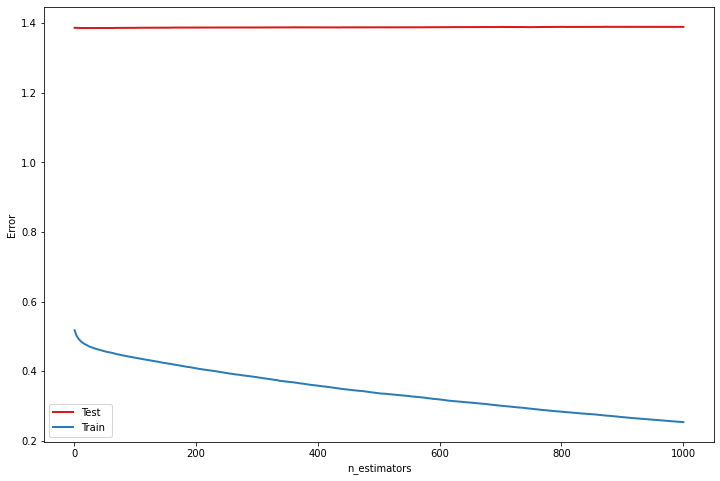

In [265]:
deviance_plot(gb, X_val, y_val, ylim=(0,0.8))
plt.legend()
plt.show()